# Project 2: Ames Housing Data and Kaggle Challenge

## Problem Statement

We have 81 features related to housing sold in Ames, IA. I have been tasked with using this data to create a model that will predict the sales price of Ames housing. I can use as many or as few features as I like keeping in mind that I don’t want to over or under fit the model.

## Executive Summary

The results provided by my Lasso Model could be improved. The higher R2 value on the train vs test data leads me to believe there is high variance (overfit). Though Lasso helps reduce variance, it does not completely eliminate it. The performance of the Ridge and Linear Regression models provided a similar R2 but were worse at predicting prices on Kaggle. Next steps would include simplifying the model to reduce variance. 

## Contents


- [Data Import and Cleaning](#Data-Import-and-Cleaning)
- [EDA](#EDA)
- [Models](#Models)
- [Results](#Results)
- [Conclusion](#Conclusion)

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
import sklearn.metrics as metrics
import missingno as msno
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV

I will begin by importing the train and test data, adding a column that differentiates between both sets, concatenating the two data sets, cleaning the data, and adding transformations and dummy variables as needed.

# Data Import and Cleaning

In [3]:
# import train data
house_train = pd.read_csv('../datasets/train.csv')
house_train.head(2)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000


In [4]:
# import test data
house_test = pd.read_csv('../datasets/test.csv')
house_test.head(2)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD


In [5]:
# add column to differentiate between train (1) and test (0) data sets
house_train['data_type'] = 1
house_test['data_type'] = 0

In [6]:
# concatenate the data to clean/transform as needed
frames = [house_train, house_test]
df = pd.concat(frames)

In [7]:
# check that data was concatenated correctly
print(house_train.shape)
print(house_test.shape)
print(df.shape)
print(house_train.shape[0] + house_test.shape[0] == df.shape[0])

(2051, 82)
(878, 81)
(2929, 82)
True


In [8]:
# There are multiple columns for the number of bathrooms, I am going to join them into one term and 
# later delete the extra columns
df['total_baths'] = df['Bsmt Full Bath'] + 0.5 * df['Bsmt Half Bath'] + df['Full Bath'] + 0.5 * df['Half Bath']

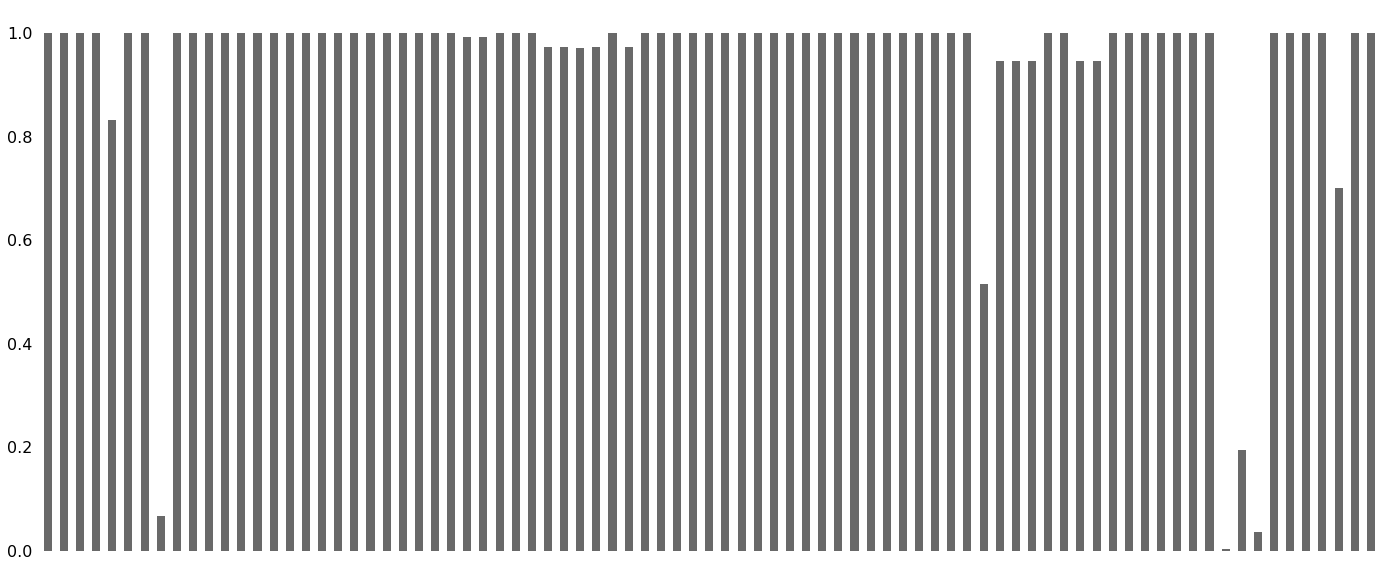

In [9]:
# plot missing values
msno.bar(df)

In [10]:
# list missing values
df.isnull().sum()[df.isnull().sum()>0]

Lot Frontage       490
Alley             2731
Mas Vnr Type        23
Mas Vnr Area        23
Bsmt Qual           80
Bsmt Cond           80
Bsmt Exposure       83
BsmtFin Type 1      80
BsmtFin SF 1         1
BsmtFin Type 2      81
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Electrical           1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1422
Garage Type        157
Garage Yr Blt      159
Garage Finish      159
Garage Cars          1
Garage Area          1
Garage Qual        159
Garage Cond        159
Pool QC           2916
Fence             2357
Misc Feature      2823
SalePrice          878
total_baths          2
dtype: int64

The null values for most categories seem to mean that the house does not have that feature. I am going to drop the columns with more than 1k null values and fill the other NaN's with zero

In [11]:
# dropping columns with a lot of null values, also dropping columns that I will not dumify based on EDA
df = df.drop(columns = ['Garage Cond', 'Garage Qual', 'Mas Vnr Type', 'Functional', 'Heating', 'BsmtFin Type 2', 'Roof Matl', 'Condition 2', 'Utilities', 'Full Bath', 'Half Bath', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Misc Feature', 'Fence', 'Pool QC', 'Fireplace Qu', 'Alley', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF'])

In [12]:
# update list missing values
df.isnull().sum()[df.isnull().sum()>0]

Lot Frontage      490
Mas Vnr Area       23
Bsmt Qual          80
Bsmt Cond          80
Bsmt Exposure      83
BsmtFin Type 1     80
Total Bsmt SF       1
Electrical          1
Garage Type       157
Garage Yr Blt     159
Garage Finish     159
Garage Cars         1
Garage Area         1
SalePrice         878
total_baths         2
dtype: int64

In [13]:
# I'm going to fill in missing data points with zero since for the most part NaN means the feature does not exist
df = df.fillna(0)

## EDA

In [14]:
# check datatypes and non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2929 entries, 0 to 877
Data columns (total 62 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2929 non-null   int64  
 1   PID              2929 non-null   int64  
 2   MS SubClass      2929 non-null   int64  
 3   MS Zoning        2929 non-null   object 
 4   Lot Frontage     2929 non-null   float64
 5   Lot Area         2929 non-null   int64  
 6   Street           2929 non-null   object 
 7   Lot Shape        2929 non-null   object 
 8   Land Contour     2929 non-null   object 
 9   Lot Config       2929 non-null   object 
 10  Land Slope       2929 non-null   object 
 11  Neighborhood     2929 non-null   object 
 12  Condition 1      2929 non-null   object 
 13  Bldg Type        2929 non-null   object 
 14  House Style      2929 non-null   object 
 15  Overall Qual     2929 non-null   int64  
 16  Overall Cond     2929 non-null   int64  
 17  Year Built     

In [15]:
# check summary statistics
df.describe()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,data_type,total_baths
count,2929.000000,2.929000e+03,2929.000000,2929.000000,2929.000000,2929.000000,2929.000000,2929.000000,2929.000000,2929.000000,...,2929.000000,2929.000000,2929.000000,2929.000000,2929.000000,2929.000000,2929.000000,2929.000000,2929.000000,2929.000000
mean,1465.255377,7.143984e+08,57.386480,57.623080,10137.697849,6.093547,5.563332,1971.344145,1984.258450,100.871287,...,23.019461,2.593377,16.007511,2.244111,50.652441,6.214749,2007.790714,127072.160464,0.700239,2.215603
std,846.003265,1.887291e+08,42.645278,33.478461,7861.902406,1.409420,1.111678,30.243350,20.859235,178.246936,...,64.148601,25.145578,56.096167,35.603235,566.440219,2.714055,1.316757,106362.524507,0.458231,0.807897
min,1.000000,5.263011e+08,20.000000,0.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,0.000000,0.000000,0.000000
25%,733.000000,5.284770e+08,20.000000,43.000000,7440.000000,5.000000,5.000000,1954.000000,1965.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,0.000000,0.000000,1.500000
50%,1465.000000,5.354532e+08,50.000000,63.000000,9434.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,134500.000000,1.000000,2.000000
75%,2198.000000,9.071811e+08,70.000000,78.000000,11553.000000,7.000000,6.000000,2001.000000,2004.000000,162.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,186800.000000,1.000000,2.500000
max,2930.000000,1.007100e+09,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000,1.000000,7.000000


Text(0.5, 1.0, 'Sales Price Histogram')

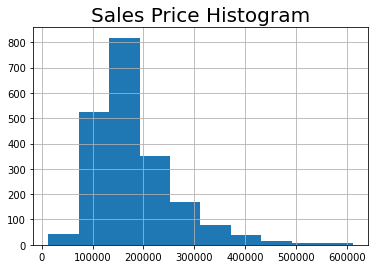

In [16]:
# Sales price, my target variable is skewed. I will take the log before using it in my model
df[df['data_type']==1]['SalePrice'].hist()
plt.title('Sales Price Histogram', fontsize = 20)

In [17]:
df[df['data_type']==1]['SalePrice'].mean()

181469.70160897123

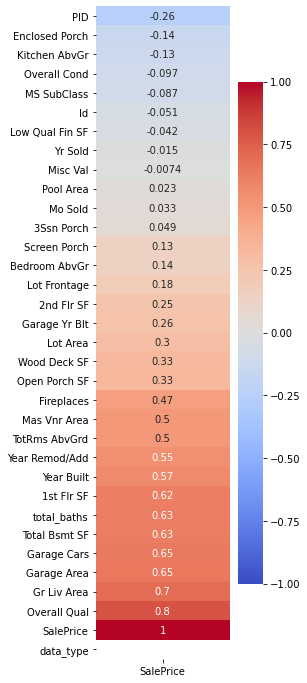

In [18]:
# The heatmap shows that overall quality, ground area, garage area, garage area in cars, total basement sf, 
# 1st floor sf, total baths, year built, year remodeled and more are highly correlated to sales price

plt.figure(figsize = (3,12))
sns.heatmap(df[df['data_type'] == 1].corr()[['SalePrice']].sort_values('SalePrice'),
           annot = True,
           vmin = -1,
           vmax = 1,
           cmap = 'coolwarm');

By graphing the features vs sales price, we can see relationships and outliers. There are two houses with a large lot area and not so high price. I am going to delete those. There are also two poins with large living area and large basement sq ft but not so high price. I will also delete those.

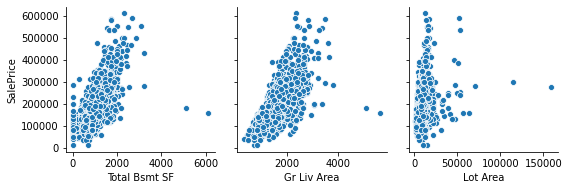

In [19]:
sns.pairplot(df[df['data_type'] == 1], x_vars = ['Total Bsmt SF', 'Gr Liv Area', 'Lot Area'], y_vars = ['SalePrice']);

In [20]:
# checking rows with high lot area
df[(df['data_type'] == 1) & (df['Lot Area'] > 100000)]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Lot Config,...,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,data_type,total_baths
471,2116,906426060,50,RL,0.0,159000,Pave,IR2,Low,CulDSac,...,0,0,0,500,6,2007,WD,277000.0,1,2.5
694,2072,905301050,20,RL,0.0,115149,Pave,IR2,Low,CulDSac,...,0,0,0,0,6,2007,WD,302000.0,1,3.0


In [21]:
# checking rows with large living area
df[(df['data_type'] == 1) & (df['Gr Liv Area'] > 4000)]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Lot Config,...,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,data_type,total_baths
960,1499,908154235,60,RL,313.0,63887,Pave,IR3,Bnk,Corner,...,0,0,480,0,1,2008,New,160000.0,1,4.5
1885,2181,908154195,20,RL,128.0,39290,Pave,IR1,Bnk,Inside,...,0,0,0,17000,10,2007,New,183850.0,1,4.0


Below are graphs I used to visualize linear relationships as well as classifiers that may not be necessary in my model

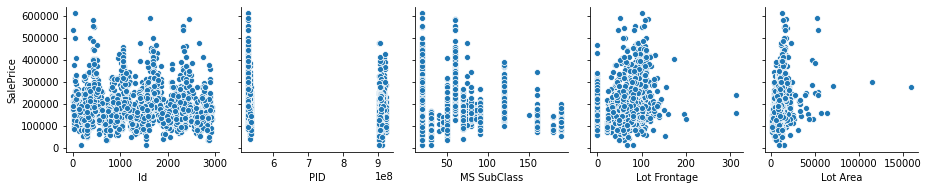

In [22]:
sns.pairplot(df[df['data_type'] == 1], x_vars = ['Id', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area'], y_vars = ['SalePrice']);

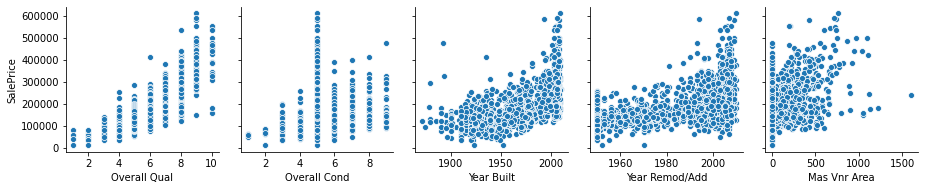

In [23]:
sns.pairplot(df[df['data_type'] == 1], x_vars = ['Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area'], y_vars = ['SalePrice']);

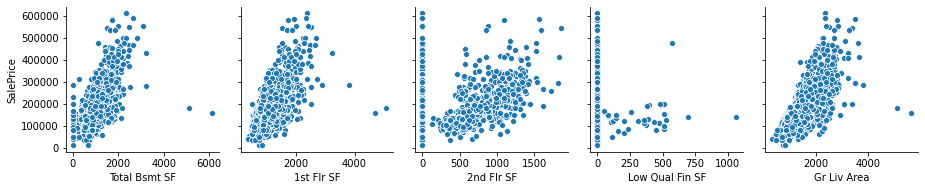

In [24]:
sns.pairplot(df[df['data_type'] == 1], x_vars = ['Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area'], y_vars = ['SalePrice']);

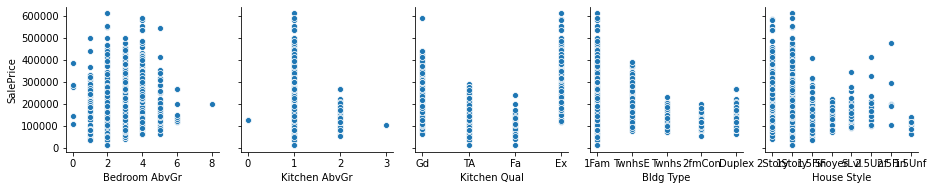

In [25]:
sns.pairplot(df[df['data_type'] == 1], x_vars = ['Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'Bldg Type', 'House Style'], y_vars = ['SalePrice']);

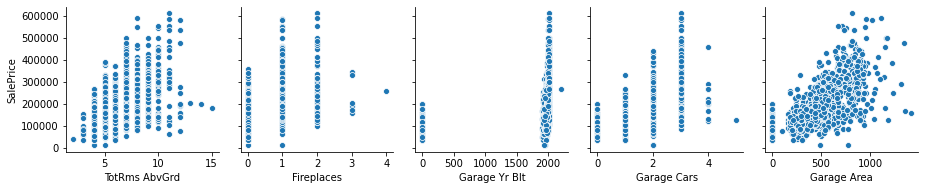

In [26]:
sns.pairplot(df[df['data_type'] == 1], x_vars = ['TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area'], y_vars = ['SalePrice']);

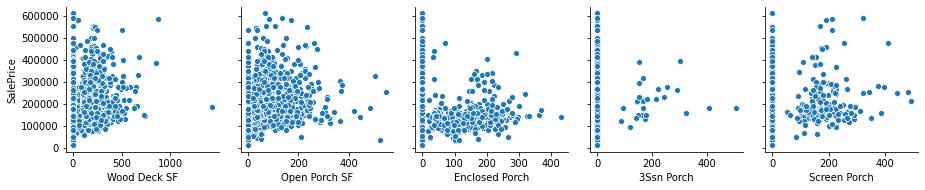

In [27]:
sns.pairplot(df[df['data_type'] == 1], x_vars = ['Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch'], y_vars = ['SalePrice']);

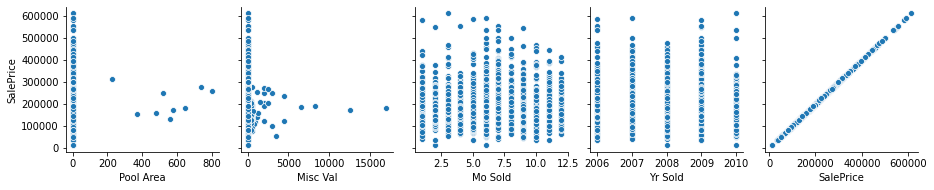

In [28]:
sns.pairplot(df[df['data_type'] == 1], x_vars = ['Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'SalePrice'], y_vars = ['SalePrice']);


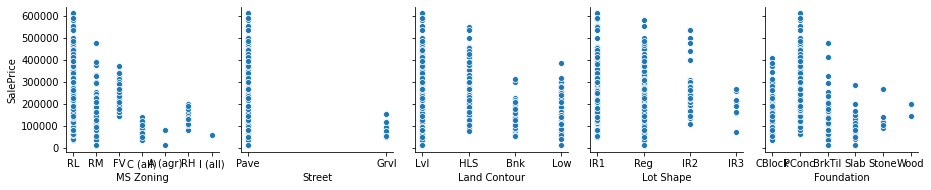

In [29]:
sns.pairplot(df[df['data_type'] == 1], x_vars = ['MS Zoning', 'Street', 'Land Contour', 'Lot Shape', 'Foundation'], y_vars = ['SalePrice']);
#'Alley' can't be graphed since it has mix of floats and strings.

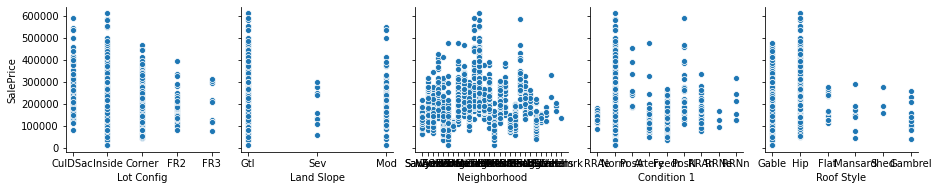

In [30]:
sns.pairplot(df[df['data_type'] == 1], x_vars = ['Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Roof Style'], y_vars = ['SalePrice']);

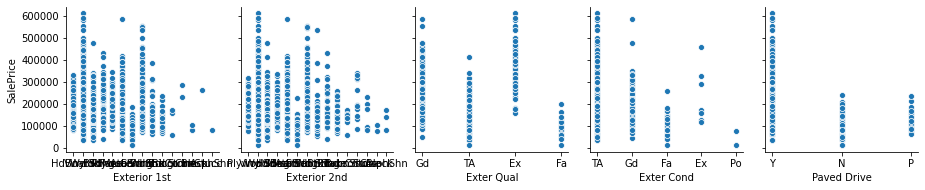

In [31]:
sns.pairplot(df[df['data_type'] == 1], x_vars = ['Exterior 1st', 'Exterior 2nd', 'Exter Qual', 'Exter Cond', 'Paved Drive'], y_vars = ['SalePrice']);

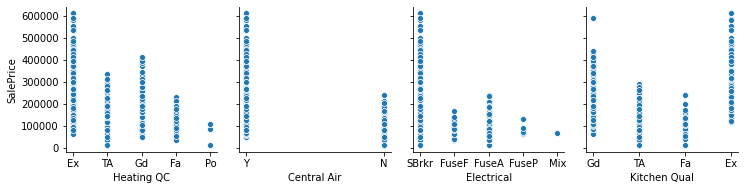

In [32]:
sns.pairplot(df[df['data_type'] == 1], x_vars = [ 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual'], y_vars = ['SalePrice']);

In [33]:
#I am going to dummify my string variables
      
df = pd.get_dummies(df, columns = ['Mo Sold', 'Yr Sold', 'MS Zoning', 'Lot Shape', 'Land Contour',
                                   'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
                                   'Bldg Type', 'House Style', 'Roof Style', 'Street',
                                   'Exterior 1st', 'Exterior 2nd', 'Exter Qual', 'Exter Cond', 
                                   'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1',
                                   'Heating QC', 'Central Air', 'Electrical', 'Sale Type',
                                   'Kitchen Qual', 'Paved Drive', 'Garage Type', 'Garage Finish', ])

In [34]:
# checking that all values are now numerical
df.dtypes[df.dtypes == 'object']

Series([], dtype: object)

In [35]:
# separating data set into train (that will further be split into train and test) and test data (that will be used for
# the Kaggle submission)
df_X = df[df['data_type'] == 1].copy()
df_X_submit = df[df['data_type'] == 0].copy()
df_y = df[df['data_type'] == 1]['SalePrice'].copy()

df_X = df_X.drop(columns = ['Id', 'PID', 'data_type', 'SalePrice'])
df_X = df_X.drop(index = [694, 471, 960, 1885])
df_y = df_y.drop(index = [694, 471, 960, 1885])
df_X_submit = df_X_submit.drop(columns = ['Id', 'PID', 'data_type', 'SalePrice'])

# Models

In [36]:
# I am not going to use polynomial features to create more interactions, this resulted in overfitting my model
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
df_overfit_train = poly.fit_transform(df_X)
df_overfit_test = poly.fit_transform(df_X_submit)

In [37]:
# The overfit dataset has too many columns. I will not use it for my model
print(df_overfit_train.shape)
print(df_X.shape)

(2047, 29160)
(2047, 240)


In [38]:
# train/test split my train data, stratify did not seem to work
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.33, random_state = 42)
y_train_log = y_train.map(np.log)
y_test_log = y_test.map(np.log)

In [39]:
# Standard Scalar, though it's not recommended to do on encoded features
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

/Users/RoxanaRuvalcaba/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/RoxanaRuvalcaba/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/RoxanaRuvalcaba/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [40]:
# Set up a list of Lasso alphas to check.
# I changed my alphas based on a comment I read on https://www.kaggle.com/apapiu/regularized-linear-models that 
# the model would not reach the optimal alpha on its own.

l_alphas = [1, 0.1, 0.001, 0.0005]
#l_alphas = np.logspace(-3, 0, 100)

# Cross-validate over our list of Lasso alphas.
lasso_cv = LassoCV(alphas = l_alphas)

# Fit model using best ridge alpha!
lasso_cv.fit(Z_train, y_train_log)

/Users/RoxanaRuvalcaba/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=[1, 0.1, 0.001, 0.0005], copy_X=True, cv='warn', eps=0.001,
    fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=None,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

# Results

In [41]:
# The R2 scores are pretty good except they are showing that my model is overfit eventhough I used the Lasso method
print(lasso_cv.score(Z_train, y_train_log))
print(lasso_cv.score(Z_test, y_test_log))

0.9463700155641666
0.8601725011687019


In [42]:
# I will create the predicted values to calculate RMSE
y_pred_train = lasso_cv.predict(Z_train)
y_pred_test = lasso_cv.predict(Z_test)

In [43]:
# RMSE for train
mse_train = metrics.mean_squared_error(np.exp(y_train_log), np.exp(y_pred_train))
rmse_train = np.sqrt(mse_train)
rmse_train

17881.255013239814

In [44]:
# RMSE for test
mse_test = metrics.mean_squared_error(np.exp(y_test_log), np.exp(y_pred_test))
rmse_test = np.sqrt(mse_test)
rmse_test

20721.004214455574

In [45]:
# optimal alpha
lasso_cv.alpha_

0.001

In [46]:
intercept = lasso_cv.intercept_

In [47]:
np.exp(intercept)

168187.3217120412

In [48]:
coefficient = lasso_cv.coef_

In [49]:
np.exp(coefficient)

array([1.        , 1.        , 1.02734524, 1.08188949, 1.05251111,
       1.05942741, 1.00824926, 1.00341998, 1.04926921, 1.00369464,
       1.        , 0.99750503, 1.12260681, 1.        , 0.98988663,
       1.00374222, 1.01654027, 1.        , 1.01035334, 1.01909702,
       1.01032699, 1.        , 1.0065925 , 1.00053232, 1.01627294,
       1.00412945, 1.00030477, 1.02552898, 1.00137333, 0.99699692,
       0.99698857, 0.99765188, 1.00196237, 1.        , 1.00450337,
       1.        , 1.00161434, 1.        , 0.99766163, 0.9985332 ,
       1.        , 1.        , 1.0019177 , 0.99759299, 1.        ,
       1.        , 0.98192353, 1.00501396, 0.99912146, 1.00067112,
       1.        , 0.98365916, 1.00038249, 0.99961743, 0.99763375,
       1.        , 1.        , 1.        , 1.        , 0.99957317,
       1.0001879 , 1.00191939, 0.99694109, 0.99892617, 1.        ,
       1.        , 1.        , 1.        , 0.99982866, 1.        ,
       0.99718753, 1.00485107, 1.00087819, 1.00077188, 1.01885

In [50]:
pd.DataFrame(data = [df_X.columns,np.exp(coefficient)]).T.sort_values(1).tail(10)

,0,1
188,Bsmt Exposure_Gd,1.01795
74,Neighborhood_Crawfor,1.01886
19,Garage Area,1.0191
27,total_baths,1.02553
2,Lot Area,1.02735
8,Total Bsmt SF,1.04927
4,Overall Cond,1.05251
5,Year Built,1.05943
3,Overall Qual,1.08189
12,Gr Liv Area,1.12261


In [53]:
y_pred_train

array([11.88153332, 12.25450485, 11.92190967, ..., 12.33172449,
       11.95107267, 12.36621954])

In [54]:
(X_train*coefficient).sum(axis = 1)+ intercept

1642    594.835914
1313    591.000912
1323    609.092241
1026    678.640513
1238    639.215432
           ...    
1133    687.231523
1297    442.283190
862     677.472184
1462    676.120495
1129    711.940409
Length: 1371, dtype: float64

In [55]:
# Scale test data to submit and predict the sales price
Z_submit = sc.transform(df_X_submit)
y_pred_submit = lasso_cv.predict(Z_submit)

/Users/RoxanaRuvalcaba/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


In [56]:
# Create data frame
Answer = pd.DataFrame(house_test['Id'])
Answer['SalePrice'] = np.exp(y_pred_submit)
Answer.tail()

,Id,SalePrice
873,1662,189116.708605
874,1234,206567.994076
875,1373,129453.863913
876,1672,116721.267822
877,1939,119868.558026


In [57]:
# Write file for Kaggle Submission
Answer.to_csv('../datasets/submit_7.csv', index = False)

In [59]:
# check submission is correct
check = pd.read_csv('../datasets/submit_7.csv')
check.shape

(878, 2)

In [60]:
Answer['SalePrice'].mean()

179872.65191759556

In [61]:
# Summary statistics
Answer['SalePrice'].describe()

count       878.000000
mean     179872.651918
std       82475.068921
min       44233.049350
25%      127493.511868
50%      159198.199306
75%      211653.060681
max      848023.292792
Name: SalePrice, dtype: float64

In [62]:
check.head()

,Id,SalePrice
0,2658,145750.904849
1,2718,161990.002680
2,2414,215340.663950
3,1989,102750.616132
4,625,174492.256189


# Conclusion

There is a lot more I would want to do with additional time such as try and reduce the high variability. From my current model, I can conclude that the best Neighborhood is Crawford for higher price housing. To improve selling price owners can can improve material and finish quality. Overall, ground living area was the most important feature and none of the features included in the model reduced the value of housing.


# Other Models

I also tried other models to see if they provided better predictions.

In [63]:
# Other models, if I had additional time, I would further reduce the features I add to my model by looking at 
# the p-values.
model = sm.OLS(df_y, df_X).fit()
model.summary()

/Users/RoxanaRuvalcaba/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/RoxanaRuvalcaba/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/RoxanaRuvalcaba/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/RoxanaRuvalcaba/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     132.3
Date:                Fri, 10 Apr 2020   Prob (F-statistic):               0.00
Time:                        08:11:38   Log-Likelihood:                -23196.
No. Observations:                2047   AIC:                         4.680e+04
Df Residuals:                    1845   BIC:                         4.793e+04
Df Model:                         201                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
MS SubClass            -32.4753     58.627     -0.554      0.580    -147.458      82.508
Lot Frontage            21.5077     18.313      1.174      0.240     -14.409      57.424
Lot Area                 1.1127      0.140      7.920      0.000       0.837       1.388
Overall Qual          6701.0007    751.661      8.915      0.000    5226.804    8175.197
Overall Cond          6443.9442    660.998      9.749      0.000    5147.562    7740.327
Year Built             322.0684     57.014      5.649      0.000     210.250     433.887
Year Remod/Add          50.8012     43.034      1.180      0.238     -33.600     135.202
Mas Vnr Area            19.9622      3.739      5.339      0.000      12.630      27.295
Total Bsmt SF           25.5978      3.082      8.305      0.000      19.553      31.643
1st Flr SF              14.9990      3.955      3.793      0.000       7.243      22.755
2nd Flr SF              20.1526      3.537      5.698      0.000      13.216      27.089
Low Qual Fin SF         -3.6501      8.339     -0.438      0.662     -20.005      12.705
Gr Liv Area             31.5014      3.504      8.990      0.000      24.629      38.374
Bedroom AbvGr        -5250.3835    971.490     -5.404      0.000   -7155.720   -3345.047
Kitchen AbvGr        -1.129e+04   4506.646     -2.506      0.012   -2.01e+04   -2455.470
TotRms AbvGrd          682.6812    696.838      0.980      0.327    -683.993    2049.355
Fireplaces            3511.3259   1029.975      3.409      0.001    1491.288    5531.364
Garage Yr Blt           -0.2753     40.755     -0.007      0.995     -80.206      79.655
Garage Cars           1992.8118   1751.340      1.138      0.255   -1442.005    5427.628
Garage Area             20.8111      6.119      3.401      0.001       8.810      32.813
Wood Deck SF            10.5861      4.408      2.402      0.016       1.941      19.231
Open Porch SF            3.3810      8.533      0.396      0.692     -13.354      20.116
Enclosed Porch           8.8046      9.557      0.921      0.357      -9.938      27.547
3Ssn Porch              -4.9116     19.913     -0.247      0.805     -43.967      34.144
Screen Porch            67.1608      9.074      7.401      0.000      49.364      84.958
Pool Area               10.8703     14.183      0.766      0.444     -16.946      38.686
Misc Val                 1.0831      1.155      0.938      0.349      -1.182       3.349
total_baths           5905.0851   1047.069      5.640      0.000    3851.520    7958.650
Mo Sold_1            -6867.9708   2974.261     -2.309      0.021   -1.27e+04   -1034.700
Mo Sold_2             -1.28e+04   2688.971     -4.760      0.000   -1.81e+04   -7525.794
Mo Sold_3            -1.188e+04   2488.174     -4.775      0.000   -1.68e+04   -7001.114
Mo Sold_4            -1.106e+04   2421.366     -4.568    

In [72]:
# Ridge
from sklearn.linear_model import Ridge

# Instantiate.
ridge = Ridge(alpha = 10)

# normalization and standardization are not the same thing, what we did before was standard sacaling, mean 0 std dev 1
# Fit.
ridge.fit(Z_train, y_train_log)

# Evaluate model using R2.
print(ridge.score(Z_train, y_train_log))
print(ridge.score(Z_test, y_test_log))

0.9478939473715793
0.861366104413744


In [65]:
ridge.coef_

array([-7.96378032e-03, -9.63248791e-05,  2.86825435e-02,  7.44299014e-02,
        5.12600058e-02,  5.52891077e-02,  7.26007236e-03,  4.74262403e-03,
        4.43552341e-02,  4.03715534e-02,  3.93154073e-02,  2.12156427e-03,
        6.76397197e-02, -2.93353896e-04, -1.24177318e-02,  8.04535261e-03,
        1.58442213e-02, -3.70843405e-03,  1.12507863e-02,  1.78473762e-02,
        1.13215189e-02, -5.68817937e-04,  8.87763545e-03,  1.72771069e-03,
        1.85566218e-02,  5.15958556e-03,  1.45715436e-03,  2.57172702e-02,
        1.98856999e-03, -3.87824486e-03, -3.48274687e-03, -3.34908083e-03,
        3.38726473e-03, -3.26664491e-04,  4.79775567e-03, -5.49747453e-04,
        3.08024282e-03,  1.48403029e-03, -3.49376994e-03, -2.33374380e-03,
        1.42504316e-04, -1.27241623e-04,  3.26006129e-03, -3.28066036e-03,
        1.21789870e-04, -4.97612931e-03, -1.86442942e-02,  9.96232639e-03,
       -4.63241115e-04,  4.46971392e-03,  7.16328278e-03, -1.03632915e-02,
        5.19520142e-04, -

In [66]:
ridge.intercept_

12.032833647413947

In [67]:
rd_sales = ridge.predict(Z_submit)

In [68]:
Answer['SalePrice']= rd_sales

In [69]:
Answer.to_csv('../datasets/Archive/submit_8.csv', index = False)

In [70]:
# Linear Regression

lr = LinearRegression()
lr.fit(X_train, y_train_log)
print(lr.score(X_train, y_train_log))
print(lr.score(X_test, y_test_log))

0.947977788471673
0.8585744120545731
